In [1]:
import sqlite3 as sql
import pandas as pd
import requests
import json
import prettytable
import bls
import os
import re

In [2]:
api_key = '5fdea5fc6e05421c82c71ccbe827486e'

### Useful Dictionaries:

In [3]:
states = [
    ("Alabama", "AL"), ("Alaska", "AK"), ("Arizona", "AZ"), ("Arkansas", "AR"), ("California", "CA"), ("Colorado", "CO"),
    ("Connecticut", "CT"), ("Delaware", "DE"), ("District of Columbia", "DC"), ("Florida", "FL"), ("Georgia", "GA"),
    ("Hawaii", "HI"), ("Idaho", "ID"), ("Illinois", "IL"), ("Indiana", "IN"), ("Iowa", "IA"), ("Kansas", "KS"),
    ("Kentucky", "KY"), ("Louisiana", "LA"), ("Maine", "ME"), ("Maryland", "MD"), ("Massachusetts", "MA"),
    ("Michigan", "MI"), ("Minnesota", "MN"), ("Mississippi", "MS"), ("Missouri", "MO"), ("Montana", "MT"),
    ("Nebraska", "NE"), ("Nevada", "NV"), ("New Hampshire", "NH"), ("New Jersey", "NJ"), ("New Mexico", "NM"),
    ("New York", "NY"), ("North Carolina", "NC"), ("North Dakota", "ND"), ("Ohio", "OH"), ("Oklahoma", "OK"),
    ("Oregon", "OR"), ("Pennsylvania", "PA"), ("Rhode Island", "RI"), ("South Carolina", "SC"), ("South Dakota", "SD"),
    ("Tennessee", "TN"), ("Texas", "TX"), ("Utah", "UT"), ("Vermont", "VT"), ("Virginia", "VA"), ("Washington", "WA"),
    ("West Virginia", "WV"), ("Wisconsin", "WI"), ("Wyoming", "WY")
]

# Sort the states alphabetically by their full names
states.sort(key=lambda x: x[0])

# Indices to skip
skip_indices = {3, 7, 14, 43, 52}

# Create the dictionary
state_dict = {}
index = 1
for full_name, abbreviation in states:
    while index in skip_indices:
        index += 1
    state_dict[index] = abbreviation
    index += 1

In [ ]:
industry_dict = {
    "11": "Agriculture, Forestry, Fishing and Hunting",
    "21": "Mining, Quarrying, and Oil and Gas Extraction",
    "22": "Utilities",
    "23": "Construction",
    "31-33": "Manufacturing",
    "42": "Wholesale Trade",
    "44-45": "Retail Trade",
    "48-49": "Transportation and Warehousing",
    "51": "Information",
    "52": "Finance and Insurance",
    "53": "Real Estate and Rental and Leasing",
    "54": "Professional, Scientific, and Technical Services",
    "55": "Management of Companies and Enterprises",
    "56": "Administrative and Support and Waste Management and Remediation Services",
    "61": "Educational Services",
    "62": "Health Care and Social Assistance",
    "71": "Arts, Entertainment, and Recreation",
    "72": "Accommodation and Food Services",
    "81": "Other Services (except Public Administration)",
    "99": "Industries not classified",
    "00": "Total for all sectors"
}

naics_codes = [code[0:2] for code in list(industry_dict.keys())[:-2]]

## Downloading txt files

In [245]:
def download_bls_table(url, output_dir="bls_data", filename=None):
    """
    Downloads a BLS table from a given URL and saves it as a text file.

    Args:
        url: The URL of the BLS table (text file).
        output_dir: The directory to save the downloaded file.
        filename: (Optional) Custom filename. If None, uses the filename from the URL.

    Returns:
        The full path to the saved file, or None if an error occurred.
    """

    try:
        # Create the output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        headers = {'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36'}
        # Fetch the file content
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)

        # Determine the filename
        if filename is None:
            # Extract filename from URL
            filename = os.path.basename(url)
            # Further improve the filename: remove any query parameters, etc.
            filename = filename.split('?')[0] # remove query parameters, if any

        # Ensure a .txt extension (or appropriate for the content)
        if not filename.lower().endswith(('.txt', '.csv', '.dat')):  # Add other likely extensions
             filename += '.txt' # Append .txt if no suitable extension is found


        # Construct the full file path
        file_path = os.path.join(output_dir, filename)

        # Save the file content
        with open(file_path, 'w', encoding='utf-8') as f:  # Use UTF-8 encoding
            f.write(response.text)

        print(f"Downloaded and saved to: {file_path}")
        return file_path

    except requests.exceptions.RequestException as e:
        print(f"Error downloading from {url}: {e}")
        return None
    except OSError as e:
        print(f"Error saving file: {e}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

In [246]:
def parse_survival_text_file(
        file_path: str,
        ) -> pd.DataFrame:
    """
    Parses BLS text file on business survival data and extracts relevant data into a DataFrame.

    Args:
        file_path (str): The path to the text file to be parsed.

    Returns:
        pd.DataFrame: A DataFrame containing the parsed data with columns:
            'Year Established', 'Year', 'Surviving Establishments', 
            'Total Employment of Survivors', 'Survival Rates Since Birth', 
            'Survival Rates of Previous Year's Survivors', 'Average Employment of Survivors'.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    current_year = None

    for line in lines:
        # Check for the "Annual openings Year ended:" line to get the current year
        year_match = re.match(r'Year ended: March (\d{4})', line)
        if year_match:
            current_year = year_match.group(1)
            continue

        # Skip lines that do not contain data
        if not re.match(r'\s*March \d{4}', line):
            continue

        # Extract data from the line
        columns = re.split(r'\s{2,}', line.strip())
        if len(columns) == 6:
            columns.insert(0, current_year)  # Insert the current year at the beginning
            columns[1] = columns[1][-4:]
            data.append(columns)

    # Create a DataFrame from the parsed data
    df = pd.DataFrame(data, columns=[
        'Year Established', 'Year', 'Surviving Establishments', 'Total Employment of Survivors',
        'Survival Rates Since Birth', 'Survival Rates of Previous Year\'s Survivors',
        'Average Employment of Survivors'
    ])

    return df

In [ ]:
survival_data = []
for state in state_dict.values():
    single_url = f"https://www.bls.gov/bdm/{state.lower()}_age_total_table7.txt"  # Survival Data
    file_path = download_bls_table(single_url)
    state_df = parse_survival_text_file(file_path)
    state_df['State'] = state
    survival_data.append(state_df)

survival_data_total = pd.concat(survival_data)

Downloaded and saved to: bls_data/al_age_total_table7.txt
Downloaded and saved to: bls_data/ak_age_total_table7.txt
Downloaded and saved to: bls_data/az_age_total_table7.txt
Downloaded and saved to: bls_data/ar_age_total_table7.txt
Downloaded and saved to: bls_data/ca_age_total_table7.txt
Downloaded and saved to: bls_data/co_age_total_table7.txt
Downloaded and saved to: bls_data/ct_age_total_table7.txt
Downloaded and saved to: bls_data/de_age_total_table7.txt
Downloaded and saved to: bls_data/dc_age_total_table7.txt
Downloaded and saved to: bls_data/fl_age_total_table7.txt
Downloaded and saved to: bls_data/ga_age_total_table7.txt
Downloaded and saved to: bls_data/hi_age_total_table7.txt
Downloaded and saved to: bls_data/id_age_total_table7.txt
Downloaded and saved to: bls_data/il_age_total_table7.txt
Downloaded and saved to: bls_data/in_age_total_table7.txt
Downloaded and saved to: bls_data/ia_age_total_table7.txt
Downloaded and saved to: bls_data/ks_age_total_table7.txt
Downloaded and

In [138]:
# Save the dataframe to the SQLite database
conn = sql.connect("states.db")
survival_data_total.to_sql("survival_rates", conn, if_exists="replace", index=False)

25296

In [255]:
industry_survival_data = []
for industry in naics_codes:
    single_url = f"https://www.bls.gov/bdm/us_age_naics_{industry}_table7.txt"  # Survival Data
    file_path = download_bls_table(single_url)
    industry_df = parse_survival_text_file(file_path)
    if industry == '31':
        industry = "31-33"
    if industry == '44':
        industry = "44-45"
    if industry == "48":
        industry = "48-49"
    industry_df['Industry'] = industry_dict[industry]
    industry_survival_data.append(industry_df)

industry_survival_data_total = pd.concat(industry_survival_data)

Downloaded and saved to: bls_data/us_age_naics_11_table7.txt
Downloaded and saved to: bls_data/us_age_naics_21_table7.txt
Downloaded and saved to: bls_data/us_age_naics_22_table7.txt
Downloaded and saved to: bls_data/us_age_naics_23_table7.txt
Downloaded and saved to: bls_data/us_age_naics_31_table7.txt
Downloaded and saved to: bls_data/us_age_naics_42_table7.txt
Downloaded and saved to: bls_data/us_age_naics_44_table7.txt
Downloaded and saved to: bls_data/us_age_naics_48_table7.txt
Downloaded and saved to: bls_data/us_age_naics_51_table7.txt
Downloaded and saved to: bls_data/us_age_naics_52_table7.txt
Downloaded and saved to: bls_data/us_age_naics_53_table7.txt
Downloaded and saved to: bls_data/us_age_naics_54_table7.txt
Downloaded and saved to: bls_data/us_age_naics_55_table7.txt
Downloaded and saved to: bls_data/us_age_naics_56_table7.txt
Downloaded and saved to: bls_data/us_age_naics_61_table7.txt
Downloaded and saved to: bls_data/us_age_naics_62_table7.txt
Downloaded and saved to:

In [257]:
# Save the dataframe to the SQLite database
conn = sql.connect("states.db")
industry_survival_data_total.to_sql("industry_survival_rates", conn, if_exists="replace", index=False)

9424

## Downloading Series files through API

In [77]:
def get_yearly_averaged_value(
        series: pd.DataFrame
        ) -> pd.DataFrame:
    '''
    Calculate the yearly averaged values from a given time series dataframe.
    
    Parameters:
    series (pd.DataFrame): A dataframe containing the time series data.
    
    Returns:
    pd.DataFrame: A dataframe with the yearly averaged values.
    '''
    # Resample the data to yearly frequency and calculate the mean for each year
    df_yearly = series.resample('Y').mean()
    
    # Rename the index to 'Year' for clarity
    df_yearly.index.name = 'Year'
    
    return df_yearly

In [ ]:
def get_series_data_by_state(
        start_year: int,
        end_year: int
        ) -> list[pd.DataFrame]:
    """
    Fetches and processes unemployment rate data for each state from the BLS API.

    Args:
        start_year (int): The starting year for the data.
        end_year (int): The ending year for the data.

    Returns:
        list: A list of DataFrames, each containing the yearly averaged unemployment rate data for a state.
    """
    state_unemployment_rates = []
    for i in range(1, 57):
        if (i != 3) & (i != 7) & (i != 14) & (i != 43) & (i != 52):
            print(i)
            state_id = str(i).zfill(2)
            series_name = f'LASST{state_id}0000000000003'
            df = bls.get_series(series_name, start_year, end_year, api_key)
            yearly_data = get_yearly_averaged_value(df).to_frame().reset_index()
            state = state_dict[i]
            yearly_data['State'] = state
            yearly_data.rename(columns={series_name: 'Unemployment Rate'}, inplace=True)
            state_unemployment_rates.append(yearly_data)
    return state_unemployment_rates
    

In [104]:
time_spent_socializing_2019 = bls.get_series('TUU10101AA01014236', 2003, 2019, api_key)
time_spent_socializing_2021 = bls.get_series('TUU10101AA01014236', 2021, 2023, api_key)
time_spent_socializing = pd.concat((time_spent_socializing_2019, time_spent_socializing_2021))

In [ ]:
state_unemployment_rates = get_series_data_by_state(1994, 2024)
state_unemployment_rates_df = pd.concat(state_unemployment_rates)
state_unemployment_rates_df['Year'] = state_unemployment_rates_df['Year'].astype(str) # Convert year to string for sqlite

1
2
4
5
6
8
9
10
11
12
13
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
44
45
46
47
48
49
50
51
53
54
55
56


Save to SQL db

In [49]:
# Save the dataframe to the SQLite database
conn = sql.connect("states.db")
state_unemployment_rates_df.to_sql("unemployment_rate", conn, if_exists="replace", index=False)
conn.close()

NameError: name 'state_unemployment_rates_df' is not defined

## Industry Data

In [ ]:
# Example mapping dictionary for sector codes (this should be expanded with actual mappings)
sic_to_naics_mapping = {
    '01': '11',  # Agriculture, Forestry, Fishing and Hunting
    '02': '11',  # Agriculture, Forestry, Fishing and Hunting
    '07': '11',  # Agriculture, Forestry, Fishing and Hunting
    '08': '11',  # Agriculture, Forestry, Fishing and Hunting
    '09': '11',  # Agriculture, Forestry, Fishing and Hunting
    '10': '21',  # Mining, Quarrying, and Oil and Gas Extraction
    '12': '21',  # Mining, Quarrying, and Oil and Gas Extraction
    '13': '21',  # Mining, Quarrying, and Oil and Gas Extraction
    '14': '21',  # Mining, Quarrying, and Oil and Gas Extraction
    '15': '23',  # Construction
    '16': '23',  # Construction
    '17': '23',  # Construction
    '20': '31-33',  # Manufacturing
    '21': '31-33',  # Manufacturing
    '22': '31-33',  # Manufacturing
    '23': '31-33',  # Manufacturing
    '24': '31-33',  # Manufacturing
    '25': '31-33',  # Manufacturing
    '26': '31-33',  # Manufacturing
    '27': '31-33',  # Manufacturing
    '28': '31-33',  # Manufacturing
    '29': '31-33',  # Manufacturing
    '30': '31-33',  # Manufacturing
    '31': '31-33',  # Manufacturing
    '32': '31-33',  # Manufacturing
    '33': '31-33',  # Manufacturing
    '34': '31-33',  # Manufacturing
    '35': '31-33',  # Manufacturing
    '36': '31-33',  # Manufacturing
    '37': '31-33',  # Manufacturing
    '38': '31-33',  # Manufacturing
    '39': '31-33',  # Manufacturing
    '40': '48-49',  # Transportation and Warehousing
    '41': '48-49',  # Transportation and Warehousing
    '42': '48-49',  # Transportation and Warehousing
    '43': '48-49',  # Transportation and Warehousing
    '44': '48-49',  # Transportation and Warehousing
    '45': '48-49',  # Transportation and Warehousing
    '46': '48-49',  # Transportation and Warehousing
    '47': '48-49',  # Transportation and Warehousing
    '48': '48-49',  # Transportation and Warehousing
    '49': '48-49',  # Transportation and Warehousing
    '50': '42',  # Wholesale Trade
    '51': '42',  # Wholesale Trade
    '52': '44-45',  # Retail Trade
    '53': '44-45',  # Retail Trade
    '54': '44-45',  # Retail Trade
    '55': '44-45',  # Retail Trade
    '56': '44-45',  # Retail Trade
    '57': '44-45',  # Retail Trade
    '58': '44-45',  # Retail Trade
    '59': '44-45',  # Retail Trade
    '60': '52',  # Finance and Insurance
    '61': '52',  # Finance and Insurance
    '62': '52',  # Finance and Insurance
    '63': '52',  # Finance and Insurance
    '64': '52',  # Finance and Insurance
    '65': '52',  # Finance and Insurance
    '67': '52',  # Finance and Insurance
    '70': '72',  # Accommodation and Food Services
    '72': '71',  # Arts, Entertainment, and Recreation
    '73': '54',  # Professional, Scientific, and Technical Services
    '75': '81',  # Other Services (except Public Administration)
    '76': '81',  # Other Services (except Public Administration)
    '78': '81',  # Other Services (except Public Administration)
    '79': '71',  # Arts, Entertainment, and Recreation
    '80': '62',  # Health Care and Social Assistance
    '81': '81',  # Other Services (except Public Administration)
    '82': '61',  # Educational Services
    '83': '62',  # Health Care and Social Assistance
    '84': '62',  # Health Care and Social Assistance
    '86': '81',  # Other Services (except Public Administration)
    '87': '54',  # Professional, Scientific, and Technical Services
    '88': '56',  # Administrative and Support and Waste Management and Remediation Services
    '89': '55',  # Management of Companies and Enterprises
    '91': '99',  # Public Administration
    '92': '99',  # Public Administration
    '93': '99',  # Public Administration
    '94': '99',  # Public Administration
    '95': '99',  # Public Administration
    '96': '99',  # Public Administration
    '97': '99',  # Public Administration
    '99': '99',  # Public Administration
}

def convert_sic_to_naics(sic_code):
    """
    Converts a SIC code to a NAICS code using the provided mapping.

    Args:
        sic_code (str): The SIC code to convert.

    Returns:
        str: The corresponding NAICS code, or None if no mapping is found.
    """
    return sic_to_naics_mapping.get(sic_code[:2], None)

,ESTAB,NAICS1997_TTL,NAICS1997,state
0,1373,All other heavy construction,23499,06
1,1373,All other heavy construction,234990,06
2,42847,Special trade contractors,235,06
3,7526,"Plumbing, heating & AC contractor",2351,06
4,7526,"Plumbing, heating & AC contractor",23511,06
...,...,...,...,...
2108,373,Farm product raw material whsle,4225,06
2109,83,Livestock,422520,06
2110,149,Grain & field bean whsle,42251,06
2111,149,Grain & field bean whsle,422510,06


In [305]:
def get_establishment_count_data(year):
    """
    Fetches establishment count data from the Census Bureau API for a specific year.

    Args:
        year (int): The year for which to fetch the data.

    Returns:
        pd.DataFrame: A DataFrame containing the establishment count data with columns:
                      'Year', 'Industry', 'State', and 'Establishments'.
    """
    if year >= 2017:
        url = f"https://api.census.gov/data/{year}/cbp?get=ESTAB,STATE&for=state:*&NAICS2017=*"
    elif year >= 2012:
        url = f"https://api.census.gov/data/{year}/cbp?get=ESTAB,NAICS2012_TTL&for=state:*&NAICS2012=*"
    elif year > 2007:
        url = f"https://api.census.gov/data/{year}/cbp?get=ESTAB,NAICS2007_TTL&for=state:*&NAICS2007=*"
    elif year > 2002:
        url = f"https://api.census.gov/data/{year}/cbp?get=ESTAB,NAICS2002_TTL&for=state:*&NAICS2002=*"
    elif year > 1997:
        url = f"https://api.census.gov/data/{year}/cbp?get=ESTAB,NAICS1997_TTL&for=state:*&NAICS1997=*"
    else:
        url = f"https://api.census.gov/data/{year}/cbp?get=ESTAB,SIC_TTL&for=state:*&SIC=*"
    
    response = requests.get(url)
    data = response.json()
    columns = data[0]
    rows = data[1:]
    df = pd.DataFrame(rows, columns=columns)
    df = df.loc[:, ~df.columns.duplicated()]
    
    # Convert NAICS or SIC codes to NAICS 2017 standard
    if year >= 2017:
        df['NAICS2017'] = df['NAICS2017']
    elif year >= 2012:
        df.rename(columns={'NAICS2012': 'NAICS2017'}, inplace=True)
    elif year > 2007:
        df.rename(columns={'NAICS2007': 'NAICS2017'}, inplace=True)
    elif year > 2002:
        df.rename(columns={'NAICS2002': 'NAICS2017'}, inplace=True)
    elif year > 1997:
        df.rename(columns={'NAICS1997': 'NAICS2017'}, inplace=True)
    else:
        df['SIC'] = df['SIC'].str.strip()
        df['SIC'] = df['SIC'].apply(lambda x: convert_sic_to_naics(x) if len(x) == 2 else None)
        df.dropna(subset=['SIC'], inplace=True)
        df.rename(columns={'SIC': 'NAICS2017'}, inplace=True)
    
    
    # Filter for valid NAICS codes and state codes
    df['NAICS2017'] = df['NAICS2017'].str.strip()
    df_filtered = df[df["NAICS2017"].str.match(r'^\d{2}\s*$|^\d{2}-\d{2}\s*$')]
    df_filtered = df_filtered[df_filtered['state'].astype('int') <= 56]
    
    # Map state codes and industry codes
    df_filtered['State'] = df_filtered['state'].astype('int').map(state_dict)
    df_filtered['Industry'] = df_filtered['NAICS2017'].map(industry_dict)
    
    # Clean up the DataFrame
    df_filtered.drop(columns=['NAICS2017'], inplace=True)
    df_filtered.rename(columns={'ESTAB': 'Establishments'}, inplace=True)
    df_filtered["Year"] = year
    
    return df_filtered[['Year', 'Industry', 'State', 'Establishments']].reset_index(drop=True)

In [ ]:
establishment_data = []
for year in range(1986,2022):
    establishment_data.append(get_establishment_count_data(year))
establishment_data_total = pd.concat(establishment_data)

In [319]:
# Save the dataframe to the SQLite database
conn = sql.connect("states.db")
establishment_data_total.to_sql("establishments", conn, if_exists="replace", index=False)
conn.close()

## Visualizations

In [4]:
conn = sql.connect("states.db")
survival = pd.read_sql_query("SELECT * FROM survival_rates", conn)
unemployment = pd.read_sql_query("SELECT * FROM unemployment_rate", conn)
conn.close()

survival["Year"] = survival["Year"].astype(int)
survival["Year Established"] = survival["Year Established"].astype(int)

# Remove commas and convert the remaining columns to float
columns_to_convert = survival.columns.difference(['State', 'Year', 'Year Established'])
survival[columns_to_convert] = survival[columns_to_convert].replace({',': ''}, regex=True).apply(pd.to_numeric, errors='coerce')

In [6]:
survival

,Year Established,Year,Surviving Establishments,Total Employment of Survivors,Survival Rates Since Birth,Survival Rates of Previous Year's Survivors,Average Employment of Survivors,State
0,1994,1994,9260,68797,100.0,NaN,7.4,AL
1,1994,1995,7275,65993,78.6,78.6,9.1,AL
2,1994,1996,6293,63045,68.0,86.5,10.0,AL
3,1994,1997,5630,60887,60.8,89.5,10.8,AL
4,1994,1998,5137,59875,55.5,91.2,11.7,AL
...,...,...,...,...,...,...,...,...
25291,2022,2023,1974,6249,76.2,76.2,3.2,WY
25292,2022,2024,1643,5815,63.4,83.2,3.5,WY
25293,2023,2023,2923,6846,100.0,NaN,2.3,WY
25294,2023,2024,2214,6736,75.7,75.7,3.0,WY


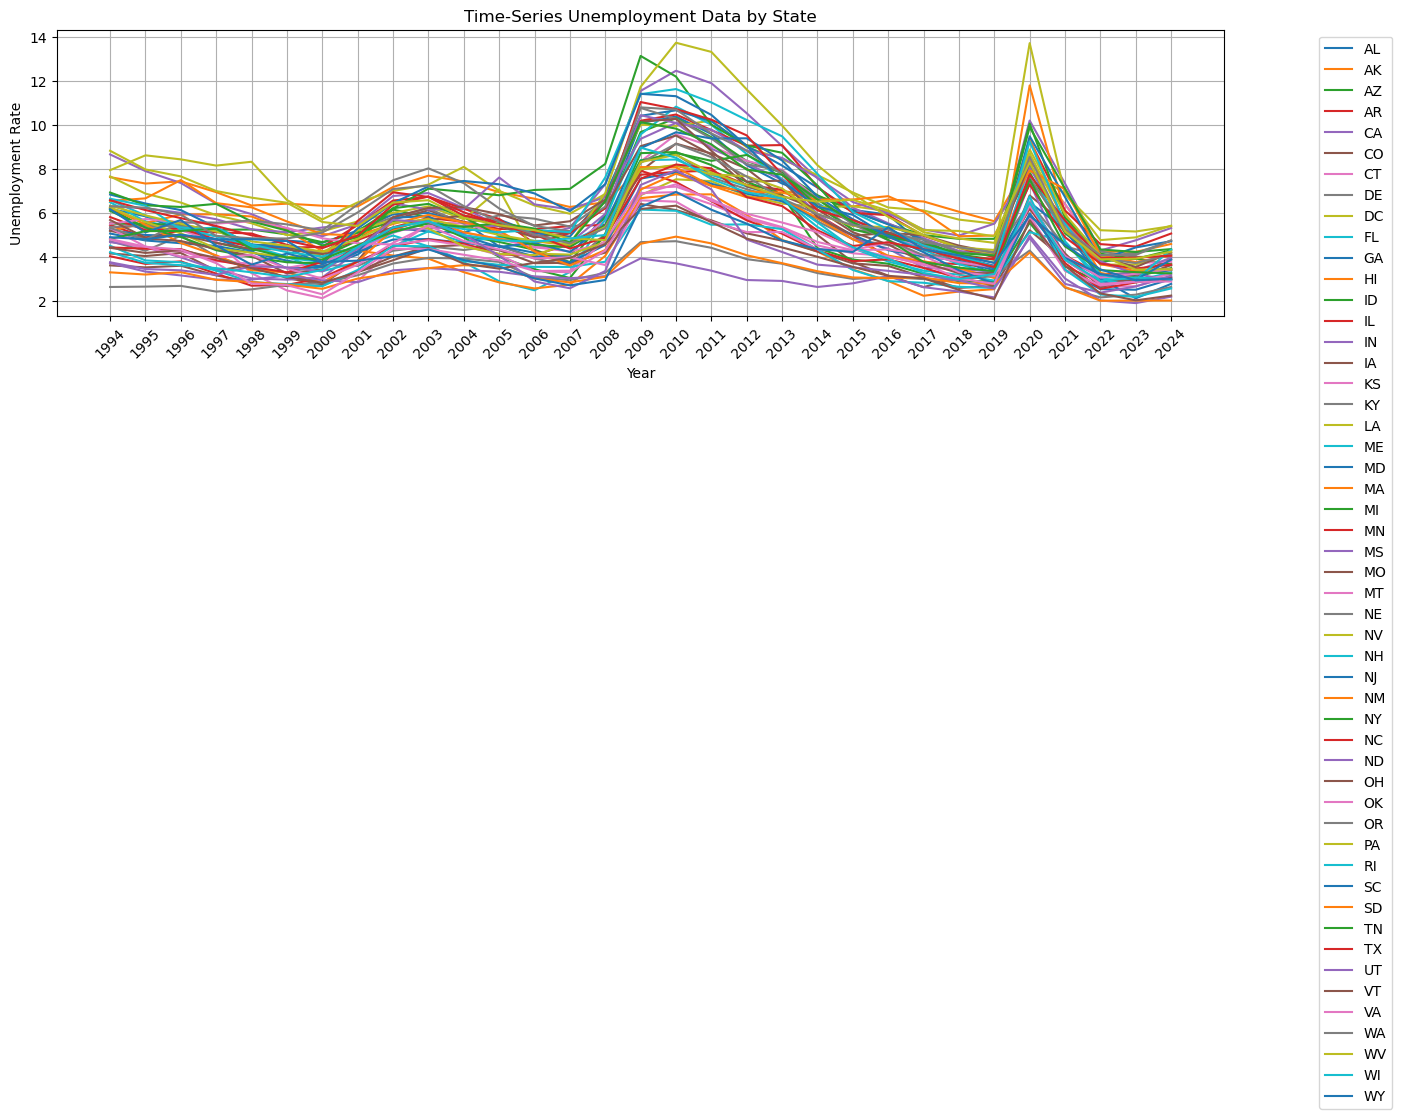

In [75]:
import matplotlib.pyplot as plt

# Plot the time-series unemployment data by state
plt.figure(figsize=(14, 8))

for state in unemployment['State'].unique():
    state_data = unemployment[unemployment['State'] == state]
    plt.plot(state_data['Year'].astype(str), state_data['Unemployment Rate'], label=state)

plt.xlabel('Year')
plt.ylabel('Unemployment Rate')
plt.title('Time-Series Unemployment Data by State')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [107]:
df_filtered = survival[survival["Year Established"] != survival["Year"]]
df_filtered = df_filtered[df_filtered["Year Established"] != df_filtered["Year"] - 1]
survival_rates_grouped_state = df_filtered.groupby(["State", "Year"]).apply(
    lambda x: (x["Survival Rates of Previous Year's Survivors"] * x["Surviving Establishments"]).sum() / x["Surviving Establishments"].sum()
)
survival_rates_grouped_nationwide = df_filtered.groupby(["Year"]).apply(
    lambda x: (x["Survival Rates of Previous Year's Survivors"] * x["Surviving Establishments"]).sum() / x["Surviving Establishments"].sum()
)

Now we can choose a state for unemployment data and survival rate data:

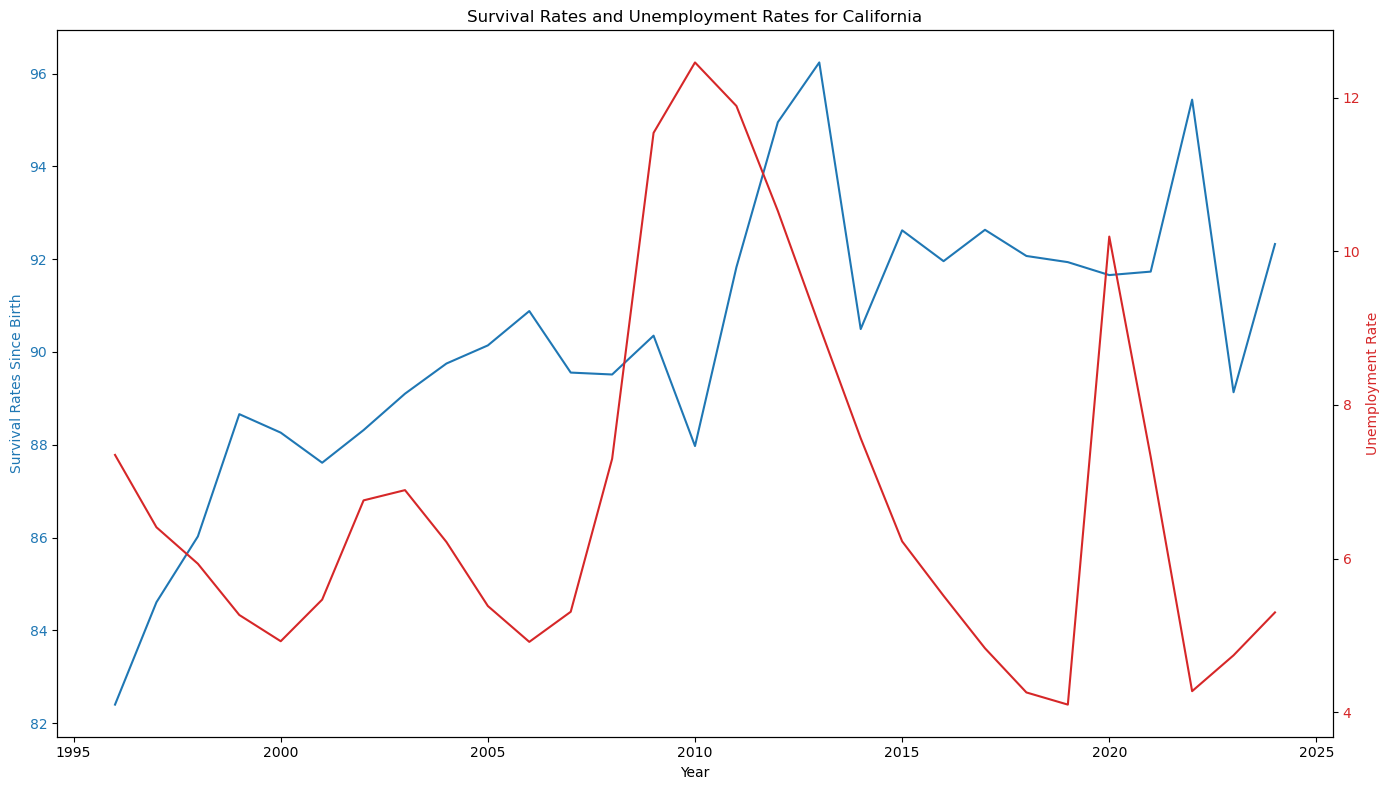

In [ ]:
import matplotlib.pyplot as plt

# Filter the data for Arizona
survival_rates_az = survival_rates_grouped_state["CA"]
unemployment_az = unemployment[(unemployment["State"] == "CA") & (unemployment["Year"].astype(int) > 1995)]
years = survival_rates_az.index.get_level_values('Year')

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the survival rates on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Survival Rates Since Birth', color=color)
ax1.plot(years, survival_rates_az.values, color=color, label='Survival Rates of Last Year\'s Surviving Businesses')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for the unemployment rates
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Unemployment Rate', color=color)
ax2.plot(years, unemployment_az['Unemployment Rate'], color=color, label='Unemployment Rate')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
plt.title('Survival Rates and Unemployment Rates for California')
fig.tight_layout()
plt.show()


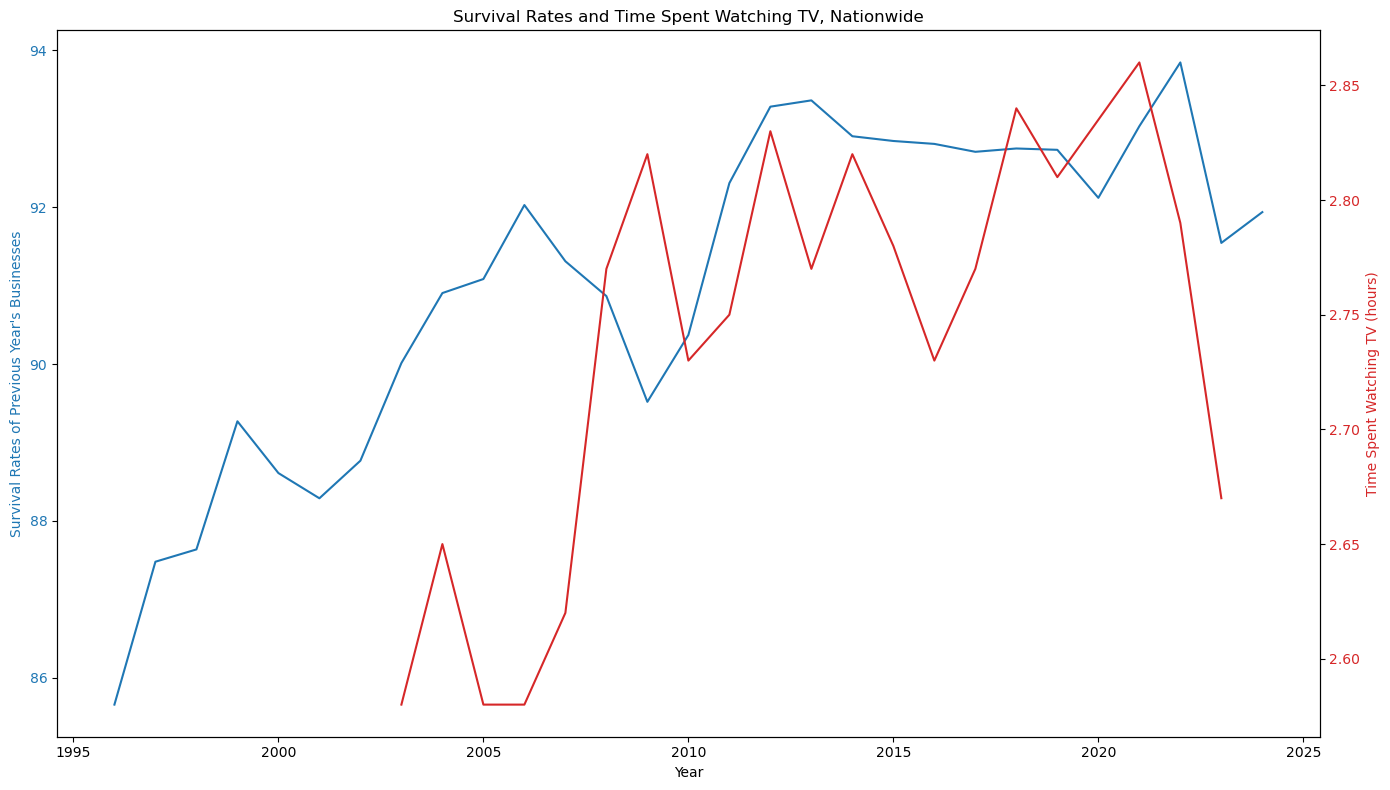

In [115]:
import matplotlib.pyplot as plt

# Filter the data for all states
survival_rates = survival_rates_grouped_nationwide
years = survival_rates.index.get_level_values('Year')

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot the survival rates on the primary y-axis
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Survival Rates of Previous Year\'s Businesses', color=color)
ax1.plot(years, survival_rates.values, color=color, label='Survival Rates of Last Year\'s Surviving Businesses')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for the unemployment rates
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Time Spent Watching TV (hours)', color=color)
ax2.plot(time_spent_socializing.index.to_timestamp().year + 1, time_spent_socializing, color=color, label='Unemployment Rate')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and show the plot
plt.title('Survival Rates and Time Spent Watching TV, Nationwide')
fig.tight_layout()
plt.show()


/var/folders/m7/6v1zwk1505d2ph7h2jch6t340000gn/T/ipykernel_45591/3437416895.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  construction_data["Year"] = construction_data["Year"].astype(int)
/var/folders/m7/6v1zwk1505d2ph7h2jch6t340000gn/T/ipykernel_45591/3437416895.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  construction_data["Establishments"] = construction_data["Establishments"].astype(int)


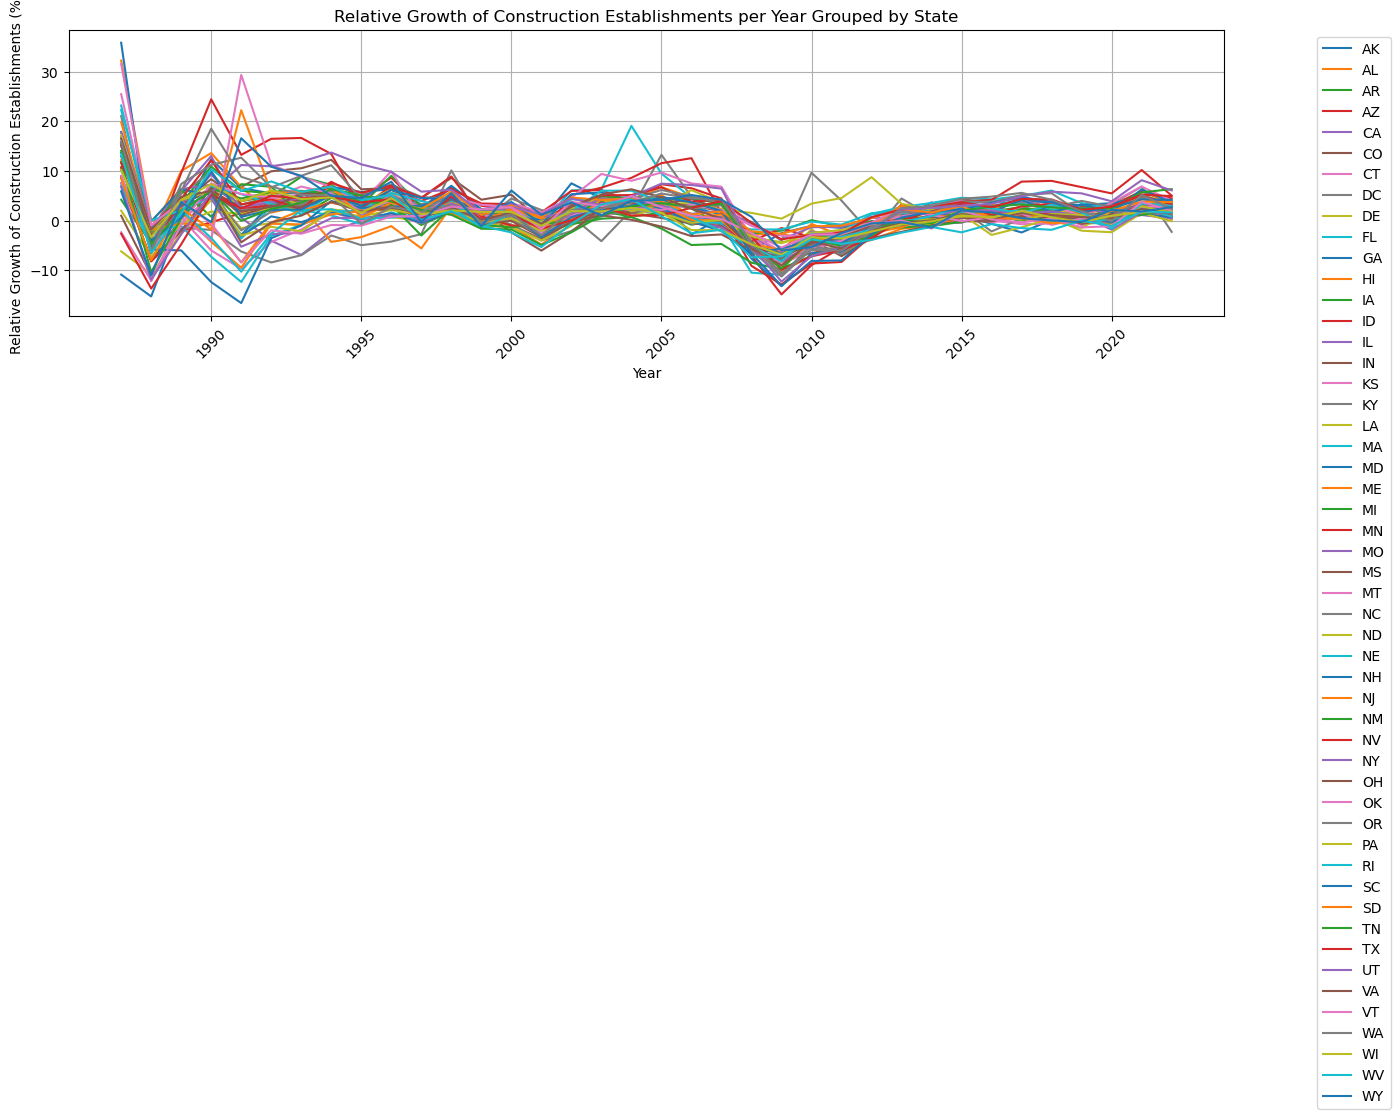

In [318]:
import matplotlib.pyplot as plt

# Filter the data for Construction industry
construction_data = establishment_data_total[establishment_data_total["Industry"] == "Construction"]

# Convert the 'Year' and 'Establishments' columns to appropriate data types
construction_data["Year"] = construction_data["Year"].astype(int)
construction_data["Establishments"] = construction_data["Establishments"].astype(int)

# Group the data by 'State' and 'Year' and sum the establishments
construction_grouped = construction_data.groupby(["State", "Year"])["Establishments"].sum().unstack()

# Calculate the relative growth
construction_growth = construction_grouped.pct_change(axis=1) * 100

# Plot the data
plt.figure(figsize=(14, 8))
for state in construction_growth.index:
    plt.plot(construction_growth.columns, construction_growth.loc[state], label=state)

plt.xlabel('Year')
plt.ylabel('Relative Growth of Construction Establishments (%)')
plt.title('Relative Growth of Construction Establishments per Year Grouped by State')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()